# 1. Import Libraries

In [40]:
# ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
#  1. Import libraries
# ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import warnings
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from xgboost.callback import EarlyStopping
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")

# 2. Data loading

In [41]:
# ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
#  2. Data loading
# ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
file_path = os.path.join("C:/Users/USSB697670/Desktop/GeorgiaTech/Data_Visual_Analytics/Project", "diabetes_prediction_dataset.csv")
df = pd.read_csv(file_path)

print(f"Dataset Shape: {df.shape}")
print(f"Missing Values:\n{df.isnull().sum()}")
print(f"Duplicate Rows: {df.duplicated().sum()}")


df.head()

Dataset Shape: (100000, 9)
Missing Values:
gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64
Duplicate Rows: 3854


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


# 3. Data cleaning & Encoding

**check for duplicates**

In [42]:
# ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
#  3. Data Cleaning
# ''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''
duplicate_rows = df[df.duplicated()]
display(duplicate_rows.head(10))
df = df.drop_duplicates().reset_index(drop=True)
print(f"Dataset Shape After Removing Duplicates: {df.shape}")


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
2756,Male,80.0,0,0,No Info,27.32,6.6,159,0
3272,Female,80.0,0,0,No Info,27.32,3.5,80,0
3418,Female,19.0,0,0,No Info,27.32,6.5,100,0
3939,Female,78.0,1,0,former,27.32,3.5,130,0
3960,Male,47.0,0,0,No Info,27.32,6.0,200,0
4106,Female,51.0,0,0,No Info,27.32,6.6,200,0
4128,Female,80.0,0,0,never,27.32,5.7,85,0
4224,Male,80.0,1,0,former,27.32,6.2,130,0
4263,Male,80.0,0,0,No Info,27.32,6.0,100,0
4486,Male,50.0,0,0,No Info,27.32,4.8,155,0


Dataset Shape After Removing Duplicates: (96146, 9)


Checking missing value

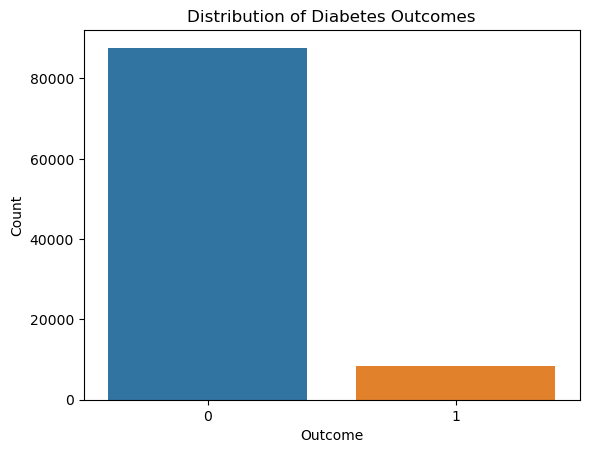

In [43]:
# print(df.isnull().sum())
sns.countplot(x=df['diabetes'], data=df)
plt.title('Distribution of Diabetes Outcomes')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.show()

Label Encoder

**Review the categorical variables**
 - **if needed, we will use label encoding**

In [44]:
# Check unique values for 'gender'
print("Unique values in 'gender':", df['gender'].unique())

# Check unique values for 'smoking_history'
print("Unique values in 'smoking_history':", df['smoking_history'].unique())


Unique values in 'gender': ['Female' 'Male' 'Other']
Unique values in 'smoking_history': ['never' 'No Info' 'current' 'former' 'ever' 'not current']


In [45]:
df = df[df["smoking_history"]!="No Info"].reset_index(drop=True)

In [46]:
print("Unique values in 'smoking_history':", df['smoking_history'].unique())


Unique values in 'smoking_history': ['never' 'current' 'former' 'ever' 'not current']


In [47]:
df["smoking_history"] = df["smoking_history"].replace("not current", "former")

**Since Gender has 3 values, we can keep the Label encoding as-is**
**However, smoking_history has 4 values, so we will use one-hot encoding**


In [48]:
# Encode 'gender'
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])


In [49]:
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,80.0,0,1,never,25.19,6.6,140,0
1,1,28.0,0,0,never,27.32,5.7,158,0
2,0,36.0,0,0,current,23.45,5.0,155,0
3,1,76.0,1,1,current,20.14,4.8,155,0
4,0,20.0,0,0,never,27.32,6.6,85,0


In [50]:
df1 = df.copy()
df['smoking_history'] = le.fit_transform(df['smoking_history'])

# 4. Feature Engineering

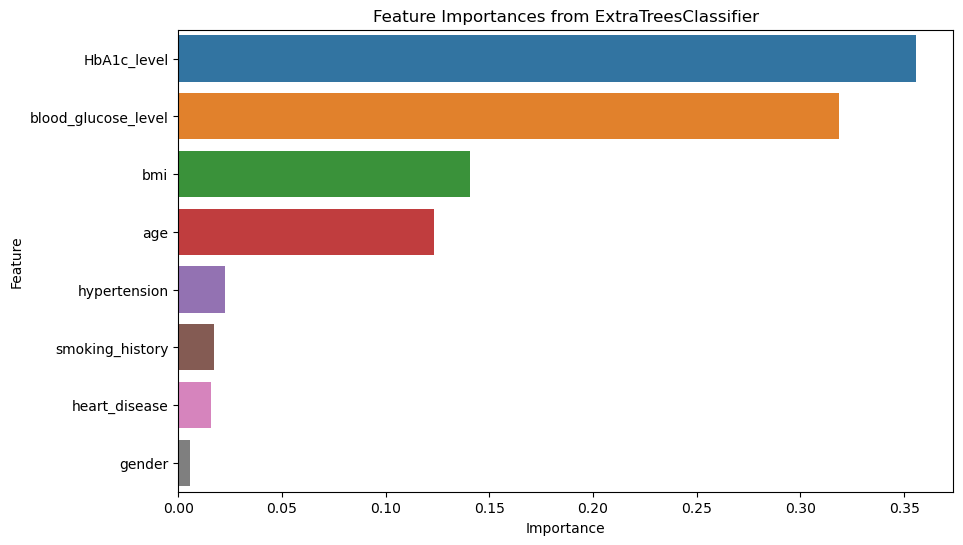

In [51]:
from sklearn.ensemble import ExtraTreesClassifier

# Define Features and Target variables
X = df.drop('diabetes', axis=1)
y = df['diabetes']

# Train ExtraTreesClassifier to identify feature importance
model = ExtraTreesClassifier()
model.fit(X, y)
# Get feature importances
importances = model.feature_importances_
# Create a DataFrame for better visualization
feat_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
# Sort the DataFrame by importance
feat_importances = feat_importances.sort_values(by='Importance', ascending=False)
# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importances)
plt.title('Feature Importances from ExtraTreesClassifier')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

**One hot encoding for smoking_history**

In [52]:
# Encode 'smoking_history' using one hot encoding
df_encoded = pd.get_dummies(df1, columns=['smoking_history'])
df_encoded = df_encoded.astype(int)

In [53]:
df_encoded

,gender,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never
0,0,80,0,1,25,6,140,0,0,0,0,1
1,1,28,0,0,27,5,158,0,0,0,0,1
2,0,36,0,0,23,5,155,0,1,0,0,0
3,1,76,1,1,20,4,155,0,1,0,0,0
4,0,20,0,0,27,6,85,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
63254,0,26,0,0,34,6,160,0,0,0,0,1
63255,0,40,0,0,40,3,155,0,0,0,0,1
63256,1,66,0,0,27,5,155,0,0,0,1,0
63257,0,24,0,0,35,4,100,0,0,0,0,1


# 5. Database setup for comparative analysis

In [54]:
import sqlite3

# Connect to SQLite database (creates if it doesn’t exist)
conn = sqlite3.connect("diabetes_results.db")
cursor = conn.cursor()

# Drop the existing table (WARNING: This will delete all previous results)
cursor.execute("DROP TABLE IF EXISTS model_results")


# Create table for storing model results
cursor.execute("""
    CREATE TABLE IF NOT EXISTS model_results (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        model_name TEXT,
        data_type TEXT,
        threshold REAL,
        precision REAL,
        recall REAL,
        f1_score REAL,
        accuracy REAL,
        run_timestamp DATETIME DEFAULT CURRENT_TIMESTAMP
    )
""")
conn.commit()
conn.close()


**utility function to store model reports into db table**

In [55]:
import sqlite3
from sklearn.metrics import classification_report

def store_classification_results(model_name, data_type, threshold, y_true, y_pred):
    """Extract classification metrics and store them in SQLite"""
    
    report = classification_report(y_true, y_pred, output_dict=True)
    
    # Extract key metrics
    precision = report["1"]["precision"]
    recall = report["1"]["recall"]
    f1_score = report["1"]["f1-score"]
    accuracy = report["accuracy"]
    
    # Store in SQLite database
    conn = sqlite3.connect("diabetes_results.db")
    cursor = conn.cursor()

    # Check if this model run already exists
    cursor.execute("""
        SELECT COUNT(*) FROM model_results
        WHERE model_name = ? AND data_type = ? AND threshold = ? AND precision = ? AND recall = ? AND accuracy = ?
    """, (model_name, data_type, threshold, precision, recall, accuracy))

    cursor.execute("""
        INSERT INTO model_results (model_name, data_type, threshold, precision, recall, f1_score, accuracy)
        VALUES (?, ?, ?, ?, ?, ?, ?)
    """, (model_name, data_type, threshold, precision, recall, f1_score, accuracy))
    
    conn.commit()
    conn.close()
    
    print(f"Results stored successfully: {model_name} (Threshold: {threshold})")



**Feature Selection**

In [56]:
# Keep all features for visualization & dashboard interaction
X_full = df_encoded.drop(columns=["diabetes"])  # Keeps everything except the target variable

# Optimized feature set (for model training)
selected_features = ["HbA1c_level", "blood_glucose_level", "bmi", "age", "hypertension", "heart_disease", "smoking_history_current", "smoking_history_ever", "smoking_history_former", "smoking_history_never"  ]
X_selected = df_encoded[selected_features]

# Target variable remains the same
y = df_encoded["diabetes"]


Splitting Data


In [57]:
# We use StratifiedFold so that each fold in x-validation has the same proportion of diabetic and non-diabetic cases as the original dataset. 
# Also ensure balanced class distribution in each fold.
# Also find the best parameters while preventing overfitting
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in skf.split(X_selected, y):
    X_train, X_test = X_selected.iloc[train_idx], X_selected.iloc[val_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[val_idx]



# 6. Feature Scaling and Normalization

- **Purpose: Feature scaling helps the model converge faster, ensures optimal performance and improves numerical stability.**
- **Method: Standardization (Z-Score Normalization)**

In [58]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.compose import ColumnTransformer

# Splitting the dataset into training and testing first
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, stratify=y, random_state=42
)


# Columns to scale
numeric_features = ["HbA1c_level", "blood_glucose_level", "bmi", "age"]

# Columns to leave unchanged
binary_features = [col for col in selected_features if col not in numeric_features]

# Create the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("bin", "passthrough", binary_features)
    ]
)

# Fitting scaler on training data only, then transforming both train and test data
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

# Converting scaled data back to DataFrame for better interpretability
X_train_scaled = pd.DataFrame(X_train_scaled, columns=preprocessor.get_feature_names_out(), index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=preprocessor.get_feature_names_out(), index=X_test.index)

# Checking the results
X_train_scaled.head()


,num__HbA1c_level,num__blood_glucose_level,num__bmi,num__age,bin__hypertension,bin__heart_disease,bin__smoking_history_current,bin__smoking_history_ever,bin__smoking_history_former,bin__smoking_history_never
44099,0.735841,-0.937847,-0.149670,-0.185402,0.0,0.0,0.0,0.0,1.0,0.0
40664,-0.151386,-1.410502,-0.302184,1.709314,0.0,0.0,0.0,0.0,1.0,0.0
19520,0.735841,0.007465,0.002845,0.070641,1.0,0.0,1.0,0.0,0.0,0.0
26218,-1.925841,0.125629,-0.454699,1.658105,1.0,0.0,1.0,0.0,0.0,0.0
49952,0.735841,-0.937847,-0.149670,1.350854,0.0,0.0,0.0,0.0,0.0,1.0


# 7. Expolratory Data Analysis

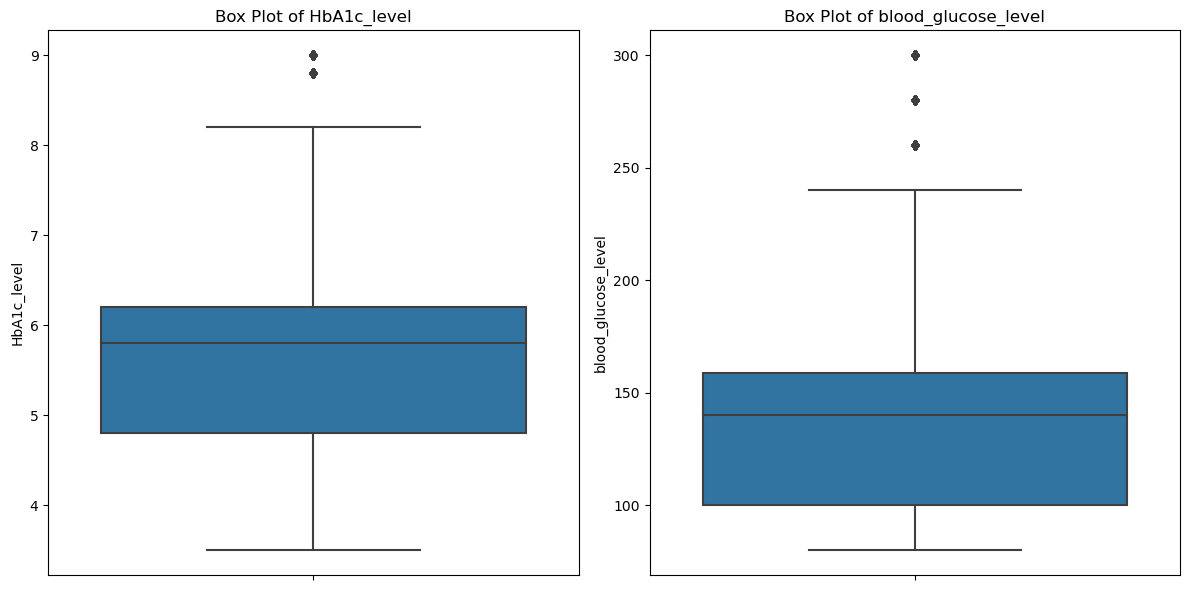

In [59]:
# List of numerical columns to check for outliers
#columns_to_check = ['bmi', 'HbA1c_level', 'blood_glucose_level']

#removed bmi as it has many outliers
columns_to_check = ['HbA1c_level', 'blood_glucose_level']

# Plot box plots for each numerical column
plt.figure(figsize=(12, 6))
for i, col in enumerate(columns_to_check, 1):
    plt.subplot(1, len(columns_to_check), i)
    sns.boxplot(y=df1[col])
    plt.title(f"Box Plot of {col}")

plt.tight_layout()
plt.show()

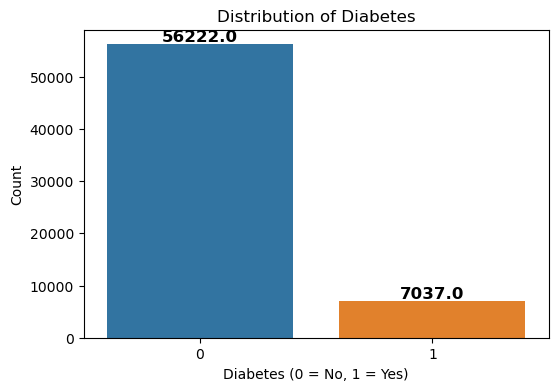

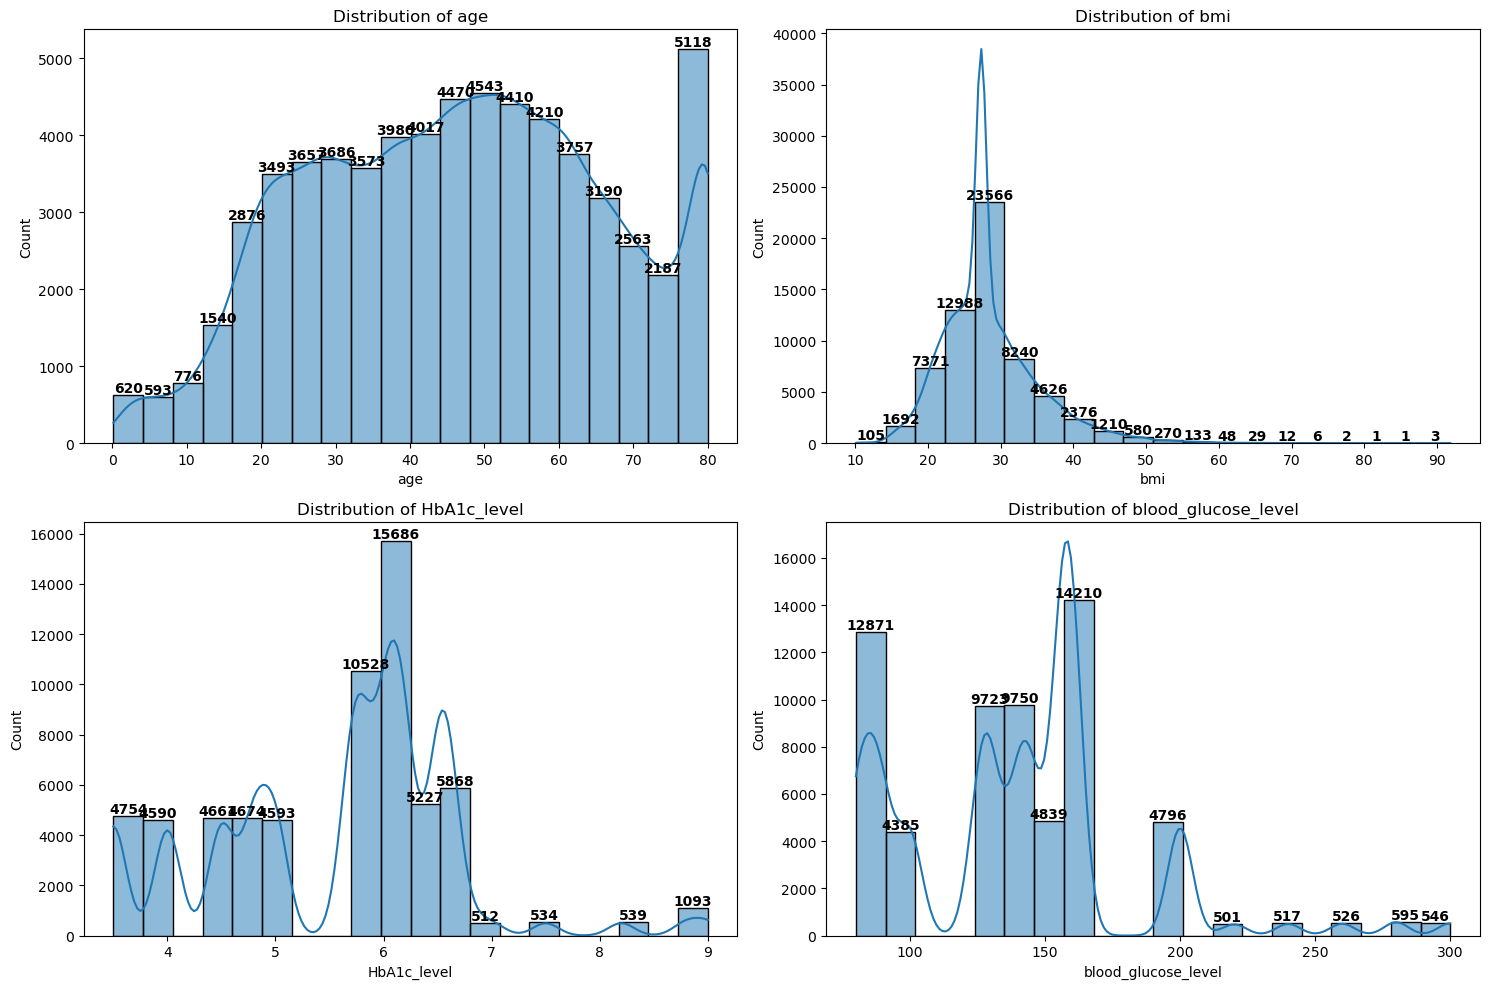

In [60]:
# Visualize the distribution of the target variable
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='diabetes', data=df1)

# Add value labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# Title and display
plt.title("Distribution of Diabetes")
plt.xlabel("Diabetes (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

# Plot distributions of numerical features
numerical_cols = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

# Create subplots for each numerical column
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 2, i)
    ax = sns.histplot(df1[col], kde=True, bins=20)

    # Add value labels on bars
    for p in ax.patches:
        if p.get_height() > 0:  # Avoid annotating empty bins
            ax.annotate(f'{int(p.get_height())}', 
                        (p.get_x() + p.get_width() / 2, p.get_height()), 
                        ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

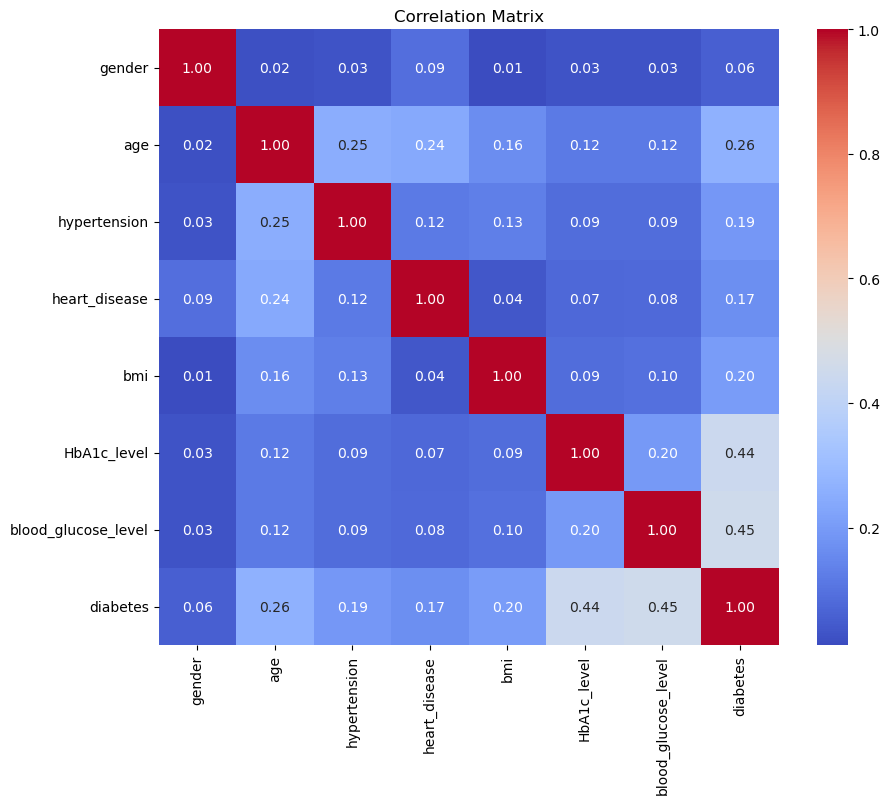

In [61]:
numeric_data = df1.select_dtypes(include=['number'])

# Compute the correlation matrix
corr_matrix = numeric_data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

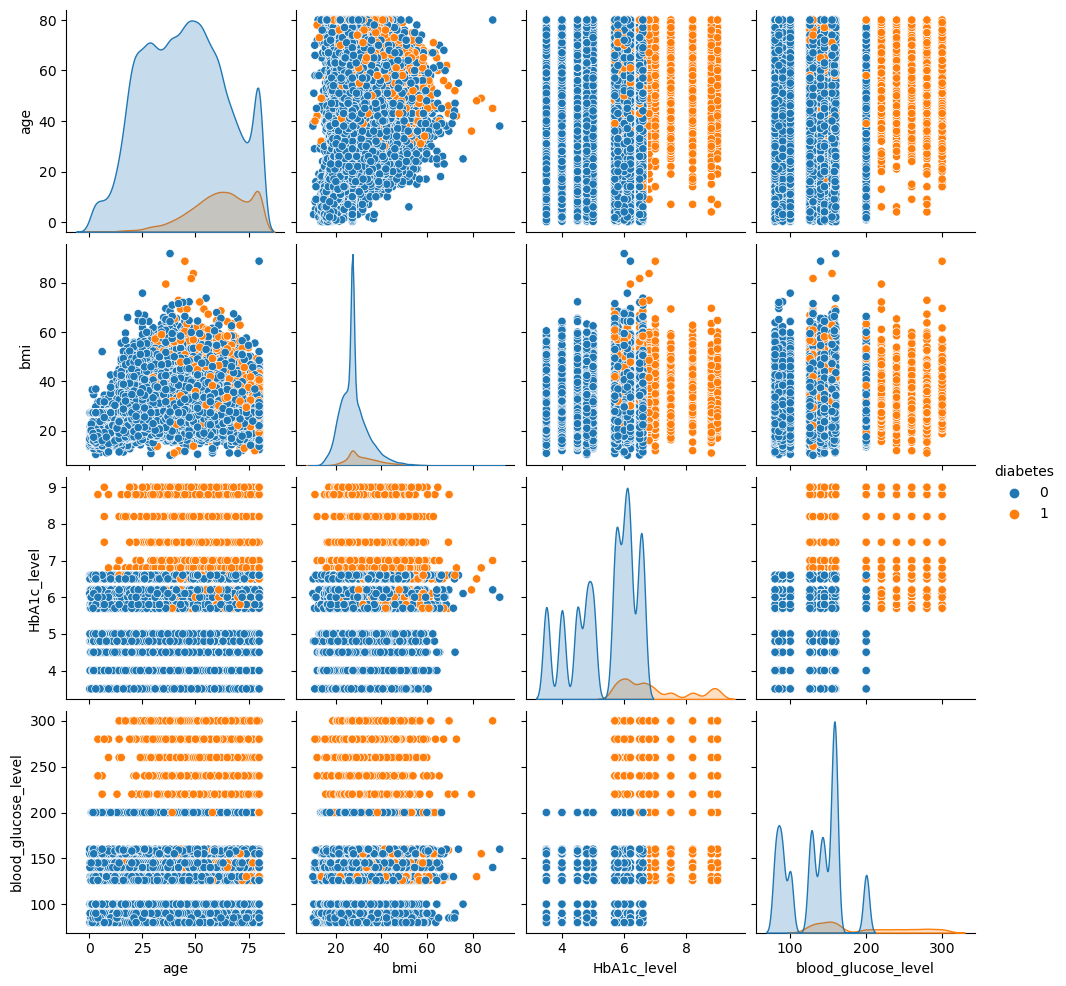

In [62]:
# Pairplot to visualize relationships between numerical columns
sns.pairplot(df1, hue='diabetes', vars=numerical_cols)
plt.show()

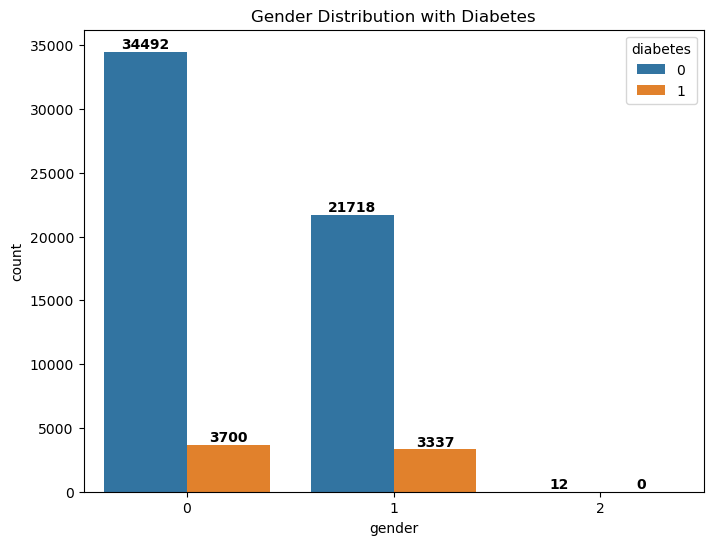

In [63]:
# Visualize gender distribution
def add_labels(ax):
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2, p.get_height()), 
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

# Visualize gender distribution with diabetes
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='gender', data=df1, hue='diabetes')
add_labels(ax)  # Add labels
plt.title("Gender Distribution with Diabetes")
plt.show()

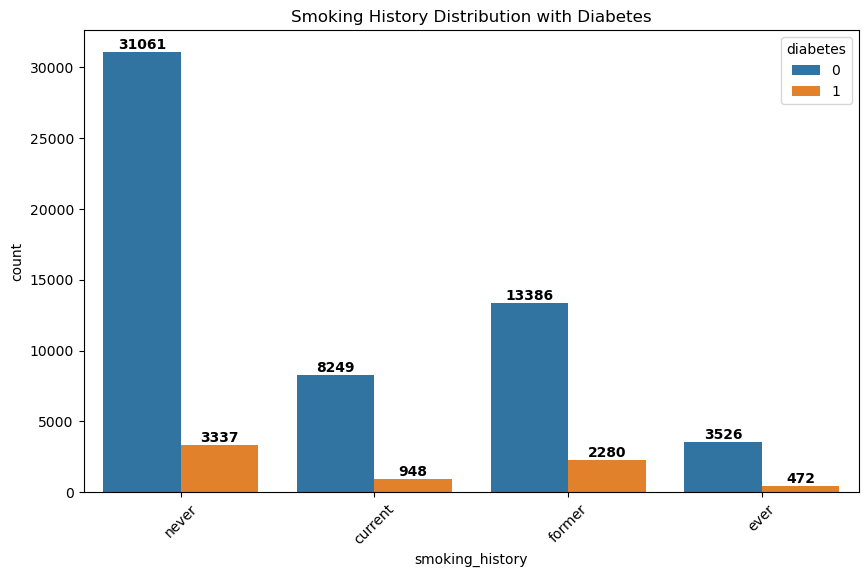

In [64]:
# Visualize smoking history distribution with diabetes
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='smoking_history', data=df1, hue='diabetes')
add_labels(ax)  # Add labels
plt.title("Smoking History Distribution with Diabetes")
plt.xticks(rotation=45)
plt.show()

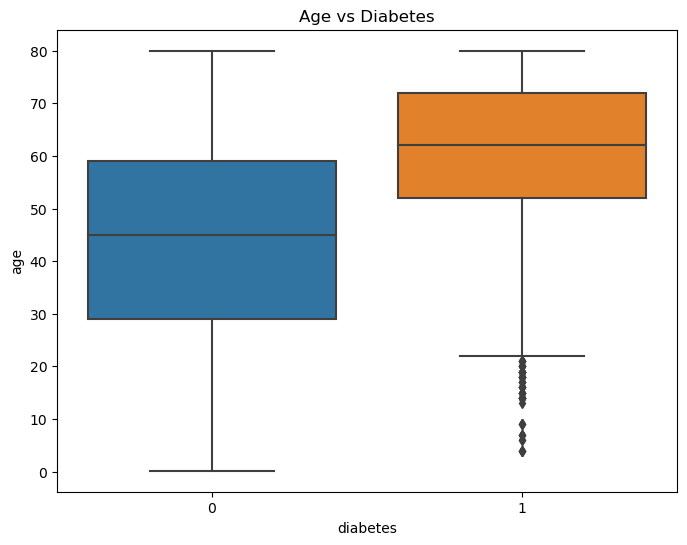

In [65]:
#Analyzing the Relationship Between Features and Target Variable

# Age vs Diabetes
plt.figure(figsize=(8, 6))
sns.boxplot(x='diabetes', y='age', data=df1)
plt.title("Age vs Diabetes")
plt.show()

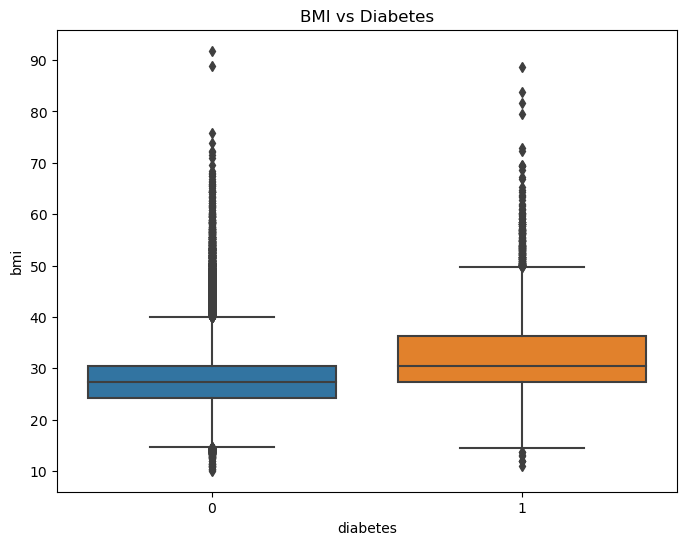

In [66]:
# BMI vs Diabetes
plt.figure(figsize=(8, 6))
sns.boxplot(x='diabetes', y='bmi', data=df1)
plt.title("BMI vs Diabetes")
plt.show()

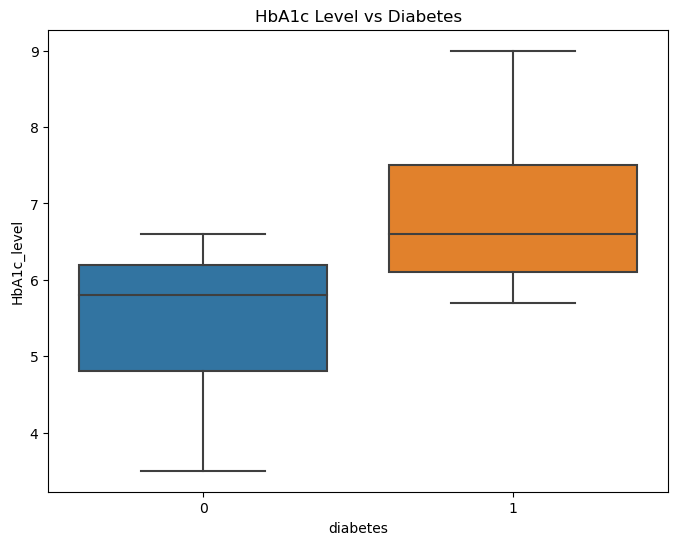

In [67]:
# HbA1c Level vs Diabetes
plt.figure(figsize=(8, 6))
sns.boxplot(x='diabetes', y='HbA1c_level', data=df1)
plt.title("HbA1c Level vs Diabetes")
plt.show()

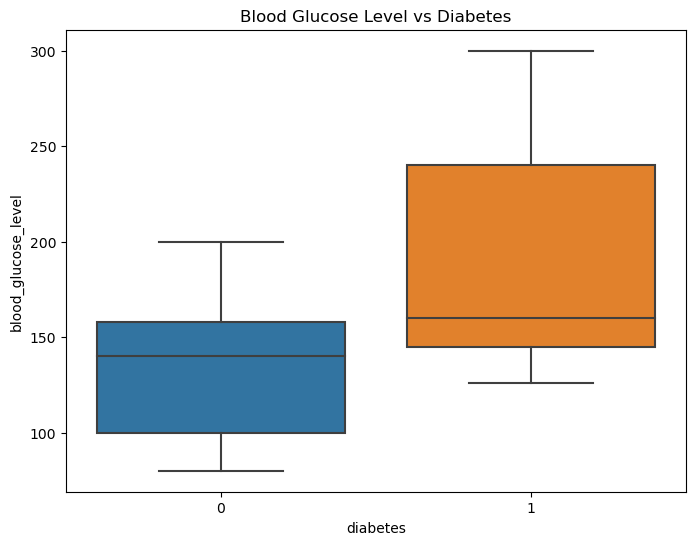

In [68]:
# Blood Glucose Level vs Diabetes
plt.figure(figsize=(8, 6))
sns.boxplot(x='diabetes', y='blood_glucose_level', data=df1)
plt.title("Blood Glucose Level vs Diabetes")
plt.show()

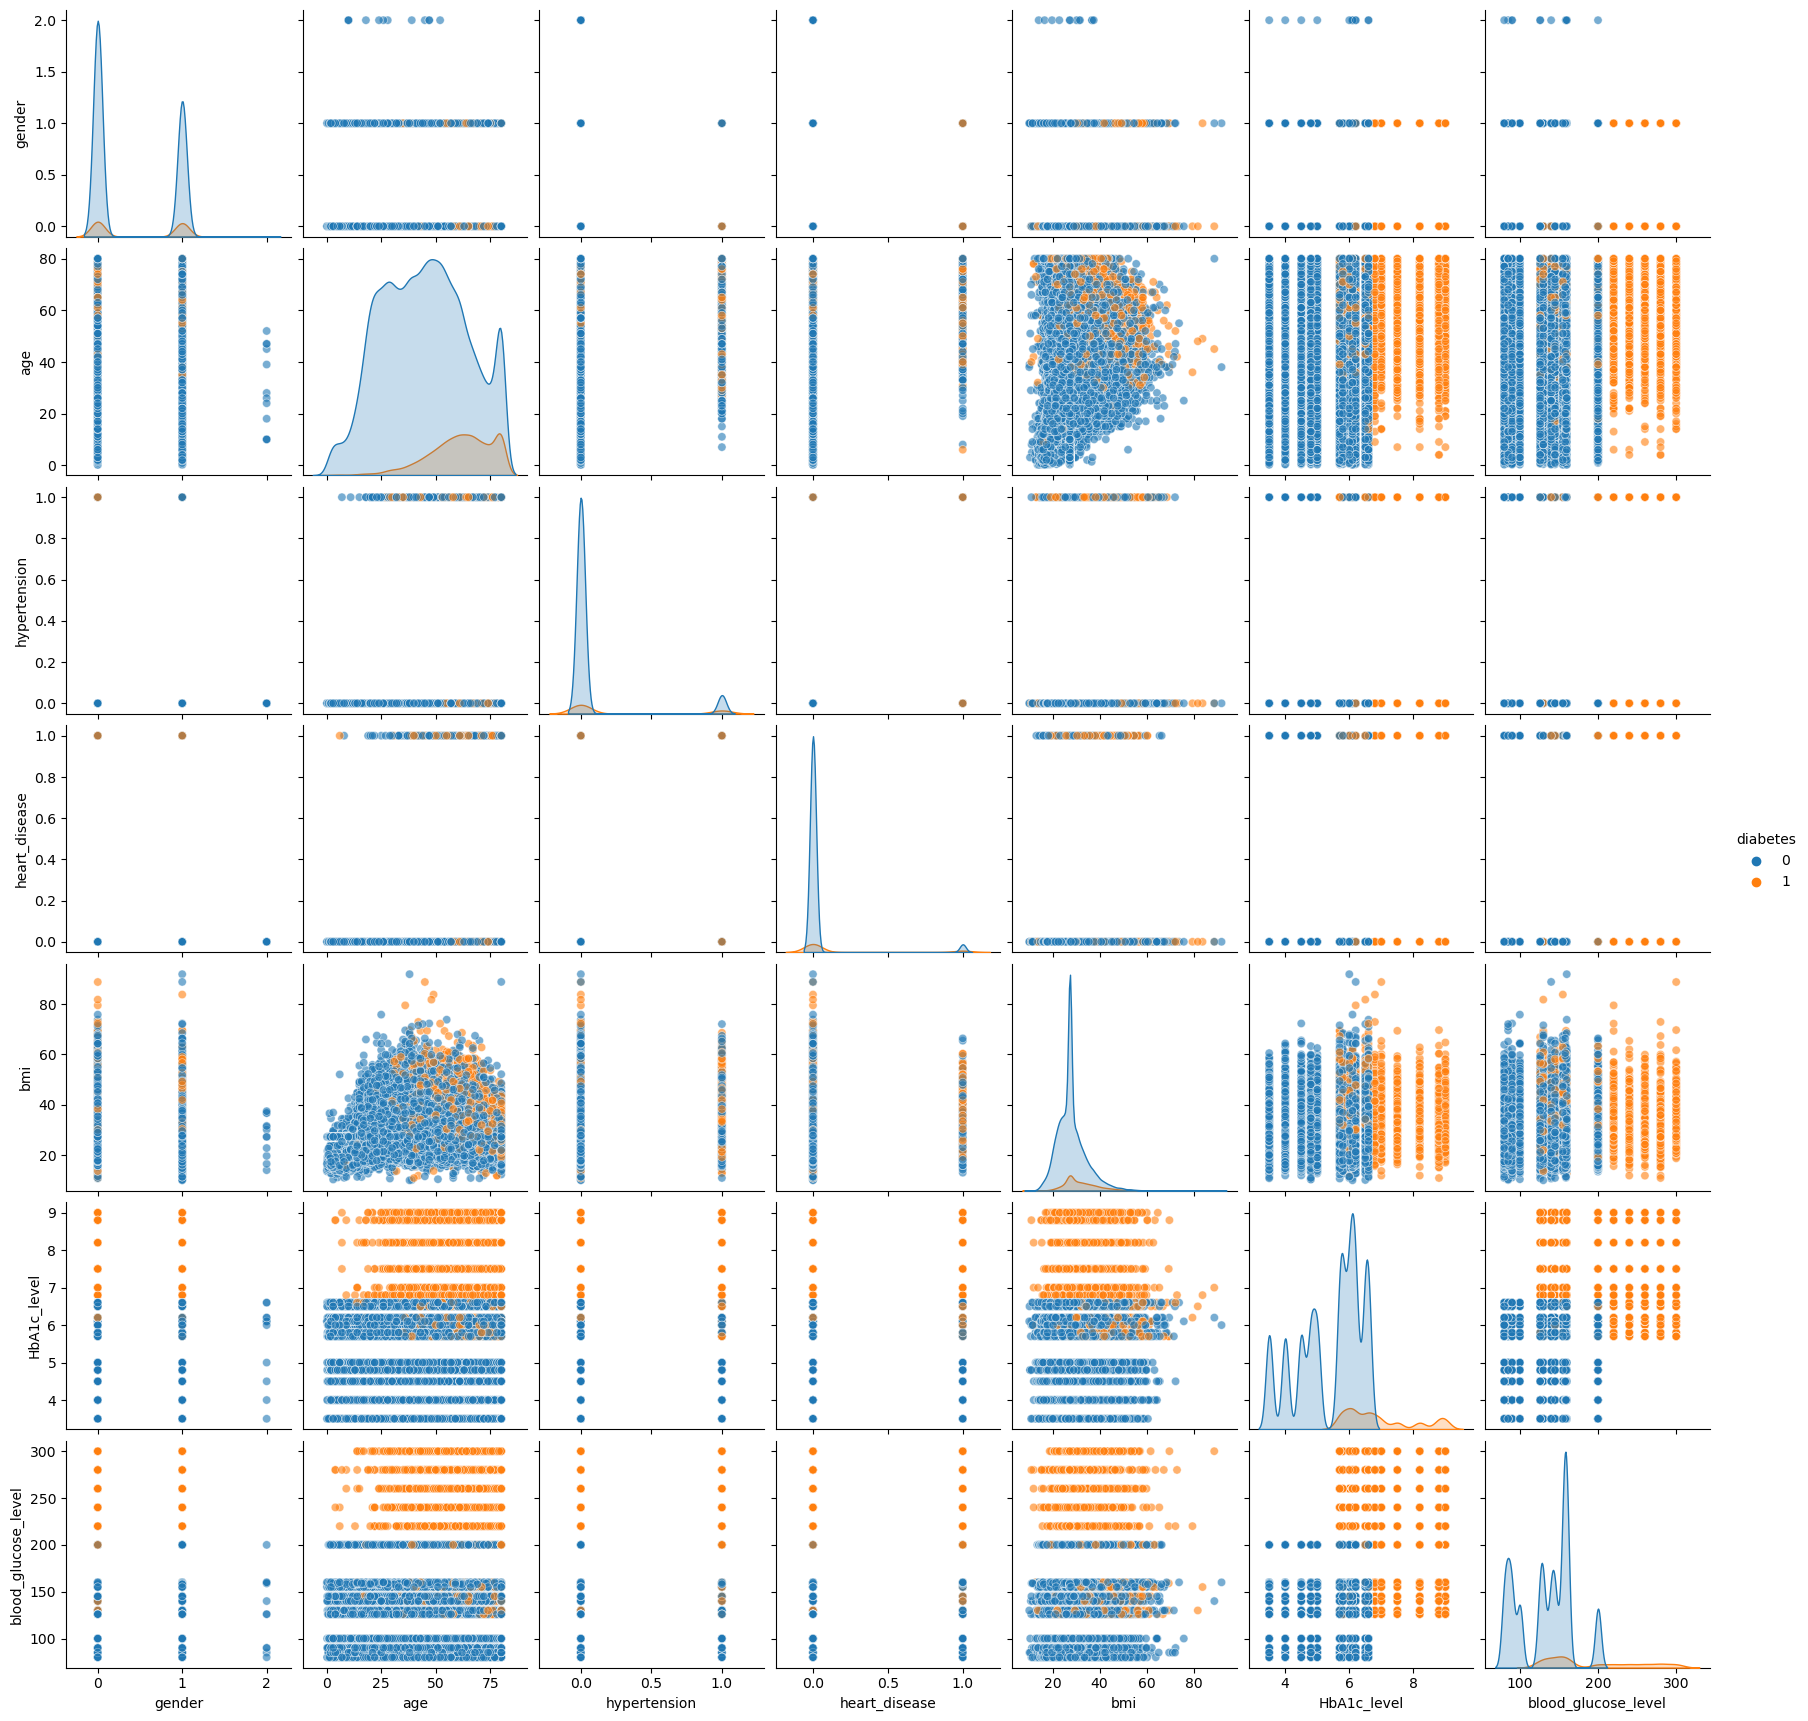

In [69]:
# Pairwise relationships with diabetes using scatterplots
sns.pairplot(df1, hue='diabetes', markers='o', plot_kws={'alpha': 0.6})
plt.show()


# 8. Model Training

#### **1. Logistic Regression- Model Training**
- **Purpose: Use as a baseline model for predicting diabetes risk.**
- **Outcome: a basic performance benchmark, demonstrates how linear relationships affect diabetes prediction.**

In [70]:
# Model Selection

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix


#Train Logistic Regression Model with scaled features
model_lr = LogisticRegression(random_state=42)
model_lr.fit(X_train_scaled, y_train)

#Evaluate and make predictions on test set
y_preds_test_lr = model_lr.predict(X_test_scaled)
store_classification_results("Logistic Regression (scaled)", "test", 0.50, y_test, y_preds_test_lr)

#Evaluate and make predictions on train set
y_preds_train_lr = model_lr.predict(X_train_scaled)
store_classification_results("Logistic Regression (scaled)", "train", 0.50, y_train, y_preds_train_lr)

# Model Performance Reports:
print("Model Performance on Test Set with Scaled Features:")
print(classification_report(y_test, y_preds_test_lr))
print("Confusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_preds_test_lr))

print("\nModel Performance on Train Set with Scaled Features:")
print(classification_report(y_train, y_preds_train_lr))
print("Confusion Matrix (Train Set):")
print(confusion_matrix(y_train, y_preds_train_lr))



Results stored successfully: Logistic Regression (scaled) (Threshold: 0.5)
Results stored successfully: Logistic Regression (scaled) (Threshold: 0.5)
Model Performance on Test Set with Scaled Features:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     11245
           1       0.84      0.62      0.71      1407

    accuracy                           0.94     12652
   macro avg       0.90      0.80      0.84     12652
weighted avg       0.94      0.94      0.94     12652

Confusion Matrix (Test Set):
[[11081   164]
 [  536   871]]

Model Performance on Train Set with Scaled Features:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     44977
           1       0.86      0.62      0.72      5630

    accuracy                           0.95     50607
   macro avg       0.91      0.80      0.84     50607
weighted avg       0.94      0.95      0.94     50607

Confusion Matrix (Train Set):


**Test SMOTE with default threshold 0.50**

In [71]:

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Apply SMOTE to the scaled training set and testing set
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)
X_test_smote, y_test_smote = smote.fit_resample(X_test_scaled, y_test)

# Step 2: Train Logistic Regression with balanced, scaled data
model_smote = LogisticRegression(random_state=42)
model_smote.fit(X_train_smote, y_train_smote)

# Step 3: Evaluate and make predictions on scaled test set
y_preds_test_smote = model_smote.predict(X_test_scaled)
store_classification_results("Logistic Regression (SMOTE & scaled)", "test", 0.50, y_test, y_preds_test_smote)

# Step 4: Evaluate and make predictions on scaled train set
y_preds_train_smote = model_smote.predict(X_train_scaled)
store_classification_results("Logistic Regression (SMOTE & scaled)", "train", 0.50, y_train, y_preds_train_smote)

# Model Performance Reports:
print("Model Performance on Test Set (SMOTE & Scaled):")
print(classification_report(y_test, y_preds_test_smote))
print("Confusion Matrix (Test Set):")
print(confusion_matrix(y_test, y_preds_test_smote))

print("\nModel Performance on Train Set (SMOTE & Scaled):")
print(classification_report(y_train, y_preds_train_smote))
print("Confusion Matrix (Train Set):")
print(confusion_matrix(y_train, y_preds_train_smote))


Results stored successfully: Logistic Regression (SMOTE & scaled) (Threshold: 0.5)
Results stored successfully: Logistic Regression (SMOTE & scaled) (Threshold: 0.5)
Model Performance on Test Set (SMOTE & Scaled):
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     11245
           1       0.58      0.78      0.67      1407

    accuracy                           0.91     12652
   macro avg       0.78      0.85      0.81     12652
weighted avg       0.93      0.91      0.92     12652

Confusion Matrix (Test Set):
[[10462   783]
 [  313  1094]]

Model Performance on Train Set (SMOTE & Scaled):
              precision    recall  f1-score   support

           0       0.97      0.93      0.95     44977
           1       0.58      0.79      0.67      5630

    accuracy                           0.91     50607
   macro avg       0.78      0.86      0.81     50607
weighted avg       0.93      0.91      0.92     50607

Confusion Matrix (Trai

In [72]:
import xgboost
print(xgboost.__version__)  # Should be >= 1.3.0


3.0.0


#### **2. XGBoost- Model Training**
- **Purpose: XGBoost is an advanced gradient boosting alg designed to handle complex interaction and non-linear relationships in structured data.**
- **Outcome: Improved predictive accuracy and robustness compared with simpler models by capturing complex patterns and interactions among features**

[0]	train-logloss:0.66802	eval-logloss:0.66840
[1]	train-logloss:0.64529	eval-logloss:0.64596
[2]	train-logloss:0.62378	eval-logloss:0.62455
[3]	train-logloss:0.60540	eval-logloss:0.60629
[4]	train-logloss:0.58674	eval-logloss:0.58779
[5]	train-logloss:0.56393	eval-logloss:0.56485
[6]	train-logloss:0.54318	eval-logloss:0.54399
[7]	train-logloss:0.52392	eval-logloss:0.52463
[8]	train-logloss:0.50681	eval-logloss:0.50750
[9]	train-logloss:0.49346	eval-logloss:0.49454
[10]	train-logloss:0.48134	eval-logloss:0.48258
[11]	train-logloss:0.46713	eval-logloss:0.46825
[12]	train-logloss:0.45380	eval-logloss:0.45490
[13]	train-logloss:0.44140	eval-logloss:0.44241
[14]	train-logloss:0.43190	eval-logloss:0.43301
[15]	train-logloss:0.42085	eval-logloss:0.42196
[16]	train-logloss:0.40988	eval-logloss:0.41090
[17]	train-logloss:0.40180	eval-logloss:0.40311
[18]	train-logloss:0.39465	eval-logloss:0.39606
[19]	train-logloss:0.38527	eval-logloss:0.38659
[20]	train-logloss:0.37659	eval-logloss:0.37787
[2

[170]	train-logloss:0.16759	eval-logloss:0.16927
[171]	train-logloss:0.16741	eval-logloss:0.16909
[172]	train-logloss:0.16695	eval-logloss:0.16854
[173]	train-logloss:0.16664	eval-logloss:0.16822
[174]	train-logloss:0.16640	eval-logloss:0.16796
[175]	train-logloss:0.16618	eval-logloss:0.16783
[176]	train-logloss:0.16553	eval-logloss:0.16718
[177]	train-logloss:0.16543	eval-logloss:0.16712
[178]	train-logloss:0.16533	eval-logloss:0.16705
[179]	train-logloss:0.16525	eval-logloss:0.16697
[180]	train-logloss:0.16461	eval-logloss:0.16631
[181]	train-logloss:0.16446	eval-logloss:0.16617
[182]	train-logloss:0.16445	eval-logloss:0.16620
[183]	train-logloss:0.16361	eval-logloss:0.16532
[184]	train-logloss:0.16340	eval-logloss:0.16512
[185]	train-logloss:0.16321	eval-logloss:0.16500
[186]	train-logloss:0.16296	eval-logloss:0.16478
[187]	train-logloss:0.16258	eval-logloss:0.16441
[188]	train-logloss:0.16243	eval-logloss:0.16429
[189]	train-logloss:0.16189	eval-logloss:0.16378
[190]	train-logloss:

[338]	train-logloss:0.13400	eval-logloss:0.13821
[339]	train-logloss:0.13386	eval-logloss:0.13816
[340]	train-logloss:0.13377	eval-logloss:0.13808
[341]	train-logloss:0.13354	eval-logloss:0.13787
[342]	train-logloss:0.13356	eval-logloss:0.13789
[343]	train-logloss:0.13355	eval-logloss:0.13789
[344]	train-logloss:0.13341	eval-logloss:0.13779
[345]	train-logloss:0.13325	eval-logloss:0.13764
[346]	train-logloss:0.13305	eval-logloss:0.13746
[347]	train-logloss:0.13303	eval-logloss:0.13745
[348]	train-logloss:0.13290	eval-logloss:0.13734
[349]	train-logloss:0.13283	eval-logloss:0.13728
[350]	train-logloss:0.13270	eval-logloss:0.13717
[351]	train-logloss:0.13259	eval-logloss:0.13711
[352]	train-logloss:0.13251	eval-logloss:0.13705
[353]	train-logloss:0.13242	eval-logloss:0.13698
[354]	train-logloss:0.13229	eval-logloss:0.13685
[355]	train-logloss:0.13215	eval-logloss:0.13673
[356]	train-logloss:0.13201	eval-logloss:0.13661
[357]	train-logloss:0.13193	eval-logloss:0.13653
[358]	train-logloss:

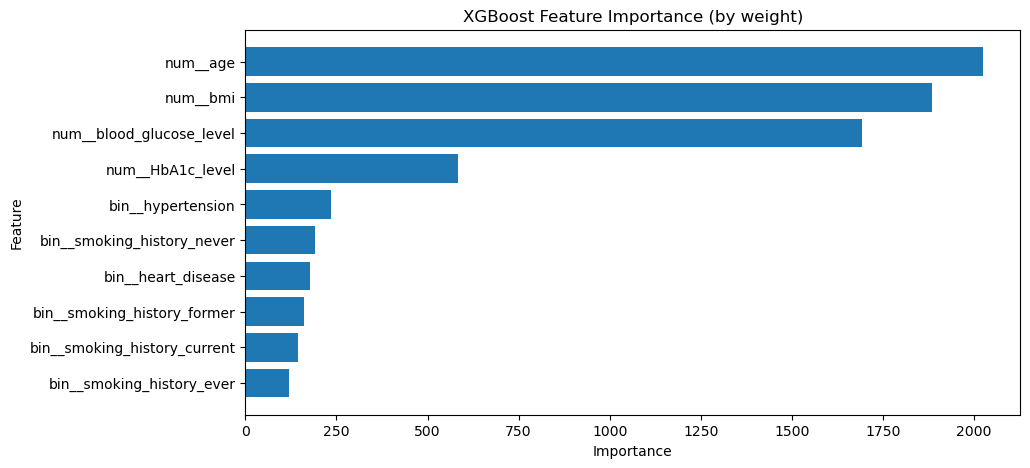

In [73]:

import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

dtrain = xgb.DMatrix(X_train_smote, label=y_train_smote)
dtest = xgb.DMatrix(X_test_smote, label=y_test_smote)

# Compute class weight ratio
scale_pos_weight = y_train_smote.value_counts()[0] / y_train_smote.value_counts()[1]

# Define XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'scale_pos_weight': scale_pos_weight,
    'learning_rate': 0.05,
    'max_depth': 5,
    'reg_alpha': 0.5,
    'reg_lambda': 2.0,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'gamma': 0.1,
    'min_child_weight': 3,
    'seed': 42
}

# Train model with early stopping
evals = [(dtrain, 'train'), (dtest, 'eval')]
bst = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=True
)

# Predict test and train
y_preds_test = bst.predict(dtest)
y_preds_test_labels = (y_preds_test >= 0.50).astype(int)

y_preds_train = bst.predict(dtrain)
y_preds_train_labels = (y_preds_train >= 0.50).astype(int)

# Store classification results
store_classification_results("XGBoost (Default threshold 50)", "test", 0.50, y_test_smote, y_preds_test_labels)
store_classification_results("XGBoost (Default threshold 50)", "train", 0.50, y_train_smote, y_preds_train_labels)

# Compute AUC-ROC
roc_auc_test = roc_auc_score(y_test_smote, y_preds_test)
roc_auc_train = roc_auc_score(y_train_smote, y_preds_train)
print(f"Test AUC-ROC: {roc_auc_test:.4f}")
print(f"Train AUC-ROC: {roc_auc_train:.4f}")

# Print classification metrics
print("\nModel Performance on Test set:")
print(classification_report(y_test_smote, y_preds_test_labels))
print("Confusion Matrix (Test Set):")
print(confusion_matrix(y_test_smote, y_preds_test_labels))

print("\nModel Performance on Train set:")
print(classification_report(y_train_smote, y_preds_train_labels))
print("Confusion Matrix (Train Set):")
print(confusion_matrix(y_train_smote, y_preds_train_labels))

# Plot built-in feature importances (from booster)
importance_dict = bst.get_score(importance_type='weight')
importance_df = pd.DataFrame({
    'Feature': list(importance_dict.keys()),
    'Importance': list(importance_dict.values())
}).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 5))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.title("XGBoost Feature Importance (by weight)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()






#### **3. Random Forest - Model Training**
- **Purpose: combines multiple decision trees to improve stability, accuracy and reduce overfitting inherent in individual decision trees**
- **Outcome: Improved accuracy and generalization compared to Logistic Regression. Useful for understanding feature importance and interactions**

Stratified K-Fold ROC AUC Scores: [0.96462945 0.96347278 0.96650563 0.96261791 0.96271229]
Average ROC AUC: 0.9640

RANDOM FOREST - TRAIN SET EVALUATION:
              precision    recall  f1-score   support

           0       0.93      0.90      0.92     44977
           1       0.82      0.86      0.84     22488

    accuracy                           0.89     67465
   macro avg       0.87      0.88      0.88     67465
weighted avg       0.89      0.89      0.89     67465

Confusion Matrix:
 [[40653  4324]
 [ 3061 19427]]
ROC AUC Score: 0.9646
Results stored successfully: Random Forest (Threshold: 0.5)

RANDOM FOREST - TEST SET EVALUATION:
              precision    recall  f1-score   support

           0       0.93      0.90      0.92     11245
           1       0.81      0.87      0.84      5622

    accuracy                           0.89     16867
   macro avg       0.87      0.89      0.88     16867
weighted avg       0.89      0.89      0.89     16867

Confusion Matrix:
 [[1

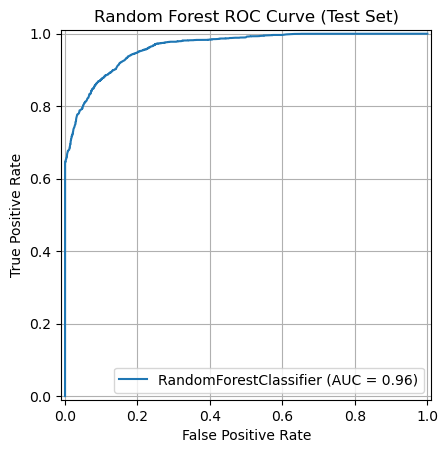

In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
)
import matplotlib.pyplot as plt


# ======== STRATIFIED K-FOLD CROSS-VALIDATION (ON TRAINING DATA ONLY) ========
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
# rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=5,  # Limit tree depth from 8 to 5 to to reduce overfitting
    min_samples_split=10,  # Reduce overfitting
    min_samples_leaf=3,  #added to reduce complexity
    max_leaf_nodes=50,  # Limit number of leaf nodes
    max_features='sqrt', # Use square root of features for each split
    class_weight='balanced', 
    random_state=42
)

cv_scores = cross_val_score(rf_model, X_train_smote, y_train_smote, cv=kfold, scoring='roc_auc')

print(f'Stratified K-Fold ROC AUC Scores: {cv_scores}')
print(f'Average ROC AUC: {cv_scores.mean():.4f}')

# ======== TRAIN RANDOM FOREST MODEL ========
rf_model.fit(X_train_smote, y_train_smote)

# Predict on train and test
y_train_pred_rf = rf_model.predict(X_train_smote)
y_test_pred_rf = rf_model.predict(X_test_smote)
y_train_proba_rf = rf_model.predict_proba(X_train_smote)[:, 1]
y_test_proba_rf = rf_model.predict_proba(X_test_smote)[:, 1]

# ========== TRAIN EVALUATION ==========
print("\nRANDOM FOREST - TRAIN SET EVALUATION:")
print(classification_report(y_train_smote, y_train_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_train_smote, y_train_pred_rf))
print(f"ROC AUC Score: {roc_auc_score(y_train_smote, y_train_proba_rf):.4f}")
store_classification_results("Random Forest", "train", 0.50, y_train_smote, y_train_pred_rf)

# ========== TEST EVALUATION ==========
print("\nRANDOM FOREST - TEST SET EVALUATION:")
print(classification_report(y_test_smote, y_test_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test_smote, y_test_pred_rf))
print(f"ROC AUC Score: {roc_auc_score(y_test_smote, y_test_proba_rf):.4f}")
store_classification_results("Random Forest", "test", 0.50, y_test_smote, y_test_pred_rf)

# ========== ROC Curve ==========
RocCurveDisplay.from_estimator(rf_model, X_test_smote, y_test_smote)
plt.title("Random Forest ROC Curve (Test Set)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.show()


#### **4. Blend XGBoost & Logistic Regression - Model Training - for better performance**
- **Purpose: The blending combines predictions from XGBoost and LR, to leverage strengths of both models for improved accuracy and stability**
- **Outcome: Enhance predictive performance and generatliation by balancing complex relationships captured by XGBoost with linear approach of Logistic Regression**

In [75]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'scale_pos_weight': scale_pos_weight,
    'learning_rate': 0.05,
    'max_depth': 5,
    'reg_alpha': 0.5,
    'reg_lambda': 2.0,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'gamma': 0.1,
    'min_child_weight': 3,
    'seed': 42
}
# Convert data into DMatrix format explicitly
dtrain = xgb.DMatrix(X_train_smote, label=y_train_smote)
dtest = xgb.DMatrix(X_test_smote, label=y_test_smote)

# Retrain using xgb.train with early stopping explicitly supported
model_xgboost_optimized = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    evals=[(dtrain, 'train'), (dtest, 'eval')],
    early_stopping_rounds=20,
    verbose_eval=True
)

# Generate Optimized XGBoost Probabilities explicitly
xgb_train_preds = model_xgboost_optimized.predict(dtrain).reshape(-1, 1)
xgb_test_preds = model_xgboost_optimized.predict(dtest).reshape(-1, 1)




# ======= Train Logistic Regression Meta-Model =======
model_logreg = LogisticRegression(random_state=42)
model_logreg.fit(xgb_train_preds, y_train_smote)

# ======= Final Ensemble Predictions =======
y_preds_train_blend_labels = model_logreg.predict(xgb_train_preds)
y_preds_test_blend_labels = model_logreg.predict(xgb_test_preds)

# ======= Store Results =======
store_classification_results("XGBoost + Logistic Regression (optimized & scaled)", "train", 0.50, y_train_smote, y_preds_train_blend_labels)
store_classification_results("XGBoost + Logistic Regression (optimized & scaled)", "test", 0.50, y_test_smote, y_preds_test_blend_labels)

# ======= Evaluate Final Ensemble Model =======
roc_auc_test = roc_auc_score(y_test_smote, y_preds_test_blend_labels)
roc_auc_train = roc_auc_score(y_train_smote, y_preds_train_blend_labels)
print(f"Test AUC-ROC: {roc_auc_test:.4f}")
print(f"Train AUC-ROC: {roc_auc_train:.4f}")

print("\nBlended Model Performance on Test set:")
print(classification_report(y_test_smote, y_preds_test_blend_labels))
print("Confusion Matrix (Test Set):")
print(confusion_matrix(y_test_smote, y_preds_test_blend_labels))

print("\nBlended Model Performance on Train set:")
print(classification_report(y_train_smote, y_preds_train_blend_labels))
print("Confusion Matrix (Train Set):")
print(confusion_matrix(y_train_smote, y_preds_train_blend_labels))


[0]	train-logloss:0.66802	eval-logloss:0.66840
[1]	train-logloss:0.64529	eval-logloss:0.64596
[2]	train-logloss:0.62378	eval-logloss:0.62455
[3]	train-logloss:0.60540	eval-logloss:0.60629
[4]	train-logloss:0.58674	eval-logloss:0.58779
[5]	train-logloss:0.56393	eval-logloss:0.56485
[6]	train-logloss:0.54318	eval-logloss:0.54399
[7]	train-logloss:0.52392	eval-logloss:0.52463
[8]	train-logloss:0.50681	eval-logloss:0.50750
[9]	train-logloss:0.49346	eval-logloss:0.49454
[10]	train-logloss:0.48134	eval-logloss:0.48258
[11]	train-logloss:0.46713	eval-logloss:0.46825
[12]	train-logloss:0.45380	eval-logloss:0.45490
[13]	train-logloss:0.44140	eval-logloss:0.44241
[14]	train-logloss:0.43190	eval-logloss:0.43301
[15]	train-logloss:0.42085	eval-logloss:0.42196
[16]	train-logloss:0.40988	eval-logloss:0.41090
[17]	train-logloss:0.40180	eval-logloss:0.40311
[18]	train-logloss:0.39465	eval-logloss:0.39606
[19]	train-logloss:0.38527	eval-logloss:0.38659
[20]	train-logloss:0.37659	eval-logloss:0.37787
[2

[170]	train-logloss:0.16759	eval-logloss:0.16927
[171]	train-logloss:0.16741	eval-logloss:0.16909
[172]	train-logloss:0.16695	eval-logloss:0.16854
[173]	train-logloss:0.16664	eval-logloss:0.16822
[174]	train-logloss:0.16640	eval-logloss:0.16796
[175]	train-logloss:0.16618	eval-logloss:0.16783
[176]	train-logloss:0.16553	eval-logloss:0.16718
[177]	train-logloss:0.16543	eval-logloss:0.16712
[178]	train-logloss:0.16533	eval-logloss:0.16705
[179]	train-logloss:0.16525	eval-logloss:0.16697
[180]	train-logloss:0.16461	eval-logloss:0.16631
[181]	train-logloss:0.16446	eval-logloss:0.16617
[182]	train-logloss:0.16445	eval-logloss:0.16620
[183]	train-logloss:0.16361	eval-logloss:0.16532
[184]	train-logloss:0.16340	eval-logloss:0.16512
[185]	train-logloss:0.16321	eval-logloss:0.16500
[186]	train-logloss:0.16296	eval-logloss:0.16478
[187]	train-logloss:0.16258	eval-logloss:0.16441
[188]	train-logloss:0.16243	eval-logloss:0.16429
[189]	train-logloss:0.16189	eval-logloss:0.16378
[190]	train-logloss:

[338]	train-logloss:0.13400	eval-logloss:0.13821
[339]	train-logloss:0.13386	eval-logloss:0.13816
[340]	train-logloss:0.13377	eval-logloss:0.13808
[341]	train-logloss:0.13354	eval-logloss:0.13787
[342]	train-logloss:0.13356	eval-logloss:0.13789
[343]	train-logloss:0.13355	eval-logloss:0.13789
[344]	train-logloss:0.13341	eval-logloss:0.13779
[345]	train-logloss:0.13325	eval-logloss:0.13764
[346]	train-logloss:0.13305	eval-logloss:0.13746
[347]	train-logloss:0.13303	eval-logloss:0.13745
[348]	train-logloss:0.13290	eval-logloss:0.13734
[349]	train-logloss:0.13283	eval-logloss:0.13728
[350]	train-logloss:0.13270	eval-logloss:0.13717
[351]	train-logloss:0.13259	eval-logloss:0.13711
[352]	train-logloss:0.13251	eval-logloss:0.13705
[353]	train-logloss:0.13242	eval-logloss:0.13698
[354]	train-logloss:0.13229	eval-logloss:0.13685
[355]	train-logloss:0.13215	eval-logloss:0.13673
[356]	train-logloss:0.13201	eval-logloss:0.13661
[357]	train-logloss:0.13193	eval-logloss:0.13653
[358]	train-logloss:

              precision    recall  f1-score   support

           0       0.96      0.97      0.96     11245
           1       0.93      0.92      0.92      5622

    accuracy                           0.95     16867
   macro avg       0.95      0.94      0.94     16867
weighted avg       0.95      0.95      0.95     16867

Confusion Matrix (Test Set):
[[10875   370]
 [  477  5145]]

Blended Model Performance on Train set:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     44977
           1       0.94      0.92      0.93     22488

    accuracy                           0.95     67465
   macro avg       0.95      0.94      0.95     67465
weighted avg       0.95      0.95      0.95     67465

Confusion Matrix (Train Set):
[[43756  1221]
 [ 1890 20598]]


# Save models and scalars

In [76]:
# ======= Save the Ensemble Models and Scaler =======
import joblib

# Save the trained XGBoost booster model
model_xgboost_optimized.save_model("model_xgboost.json")

# Save the trained Logistic Regression model
joblib.dump(model_logreg, "model_logreg.pkl")

# Save the scaler used for preprocessing
joblib.dump(preprocessor, "scaler.pkl")

print("Models and scaler have been saved successfully.")


Models and scaler have been saved successfully.


**iwith emphasis on balancing bias and variance, we systematically optimized the hyperparameters using GridSearchCV and retrained the XGBoost model explicitly via the native API (xgb.train). This provided a robust solution with explicit early stopping, significantly enhancing model generalization and performance stability.**

# **TESTING**
 - **Include all unit testing below**


In [77]:
df_encoded.describe

<bound method NDFrame.describe of        gender  age  hypertension  heart_disease  bmi  HbA1c_level  \
0           0   80             0              1   25            6   
1           1   28             0              0   27            5   
2           0   36             0              0   23            5   
3           1   76             1              1   20            4   
4           0   20             0              0   27            6   
...       ...  ...           ...            ...  ...          ...   
63254       0   26             0              0   34            6   
63255       0   40             0              0   40            3   
63256       1   66             0              0   27            5   
63257       0   24             0              0   35            4   
63258       0   57             0              0   22            6   

       blood_glucose_level  diabetes  smoking_history_current  \
0                      140         0                        0   
1      

In [78]:
df_encoded.info

<bound method DataFrame.info of        gender  age  hypertension  heart_disease  bmi  HbA1c_level  \
0           0   80             0              1   25            6   
1           1   28             0              0   27            5   
2           0   36             0              0   23            5   
3           1   76             1              1   20            4   
4           0   20             0              0   27            6   
...       ...  ...           ...            ...  ...          ...   
63254       0   26             0              0   34            6   
63255       0   40             0              0   40            3   
63256       1   66             0              0   27            5   
63257       0   24             0              0   35            4   
63258       0   57             0              0   22            6   

       blood_glucose_level  diabetes  smoking_history_current  \
0                      140         0                        0   
1        

In [79]:
import pandas as pd

# Load stored results into a DataFrame
conn = sqlite3.connect("diabetes_results.db")
df_results = pd.read_sql("SELECT * FROM model_results", conn)
conn.close()

# Display results
print(df_results)


   id                                         model_name data_type  threshold  \
0   1                       Logistic Regression (scaled)      test        0.5   
1   2                       Logistic Regression (scaled)     train        0.5   
2   3               Logistic Regression (SMOTE & scaled)      test        0.5   
3   4               Logistic Regression (SMOTE & scaled)     train        0.5   
4   5                     XGBoost (Default threshold 50)      test        0.5   
5   6                     XGBoost (Default threshold 50)     train        0.5   
6   7                                      Random Forest     train        0.5   
7   8                                      Random Forest      test        0.5   
8   9  XGBoost + Logistic Regression (optimized & sca...     train        0.5   
9  10  XGBoost + Logistic Regression (optimized & sca...      test        0.5   

   precision    recall  f1_score  accuracy        run_timestamp  
0   0.841546  0.619048  0.713350  0.944673

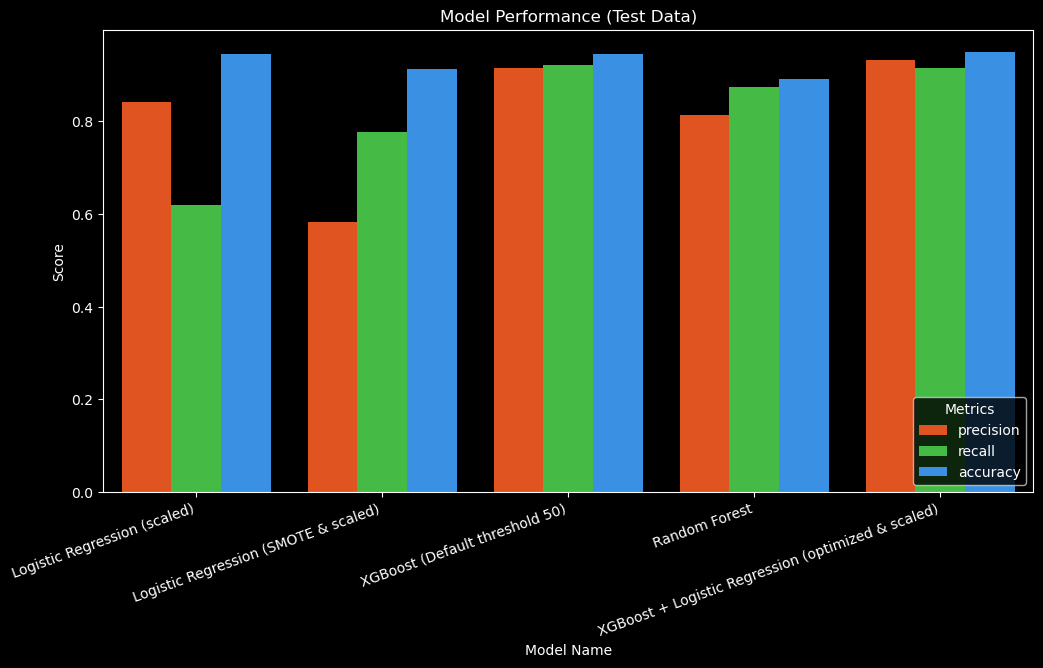

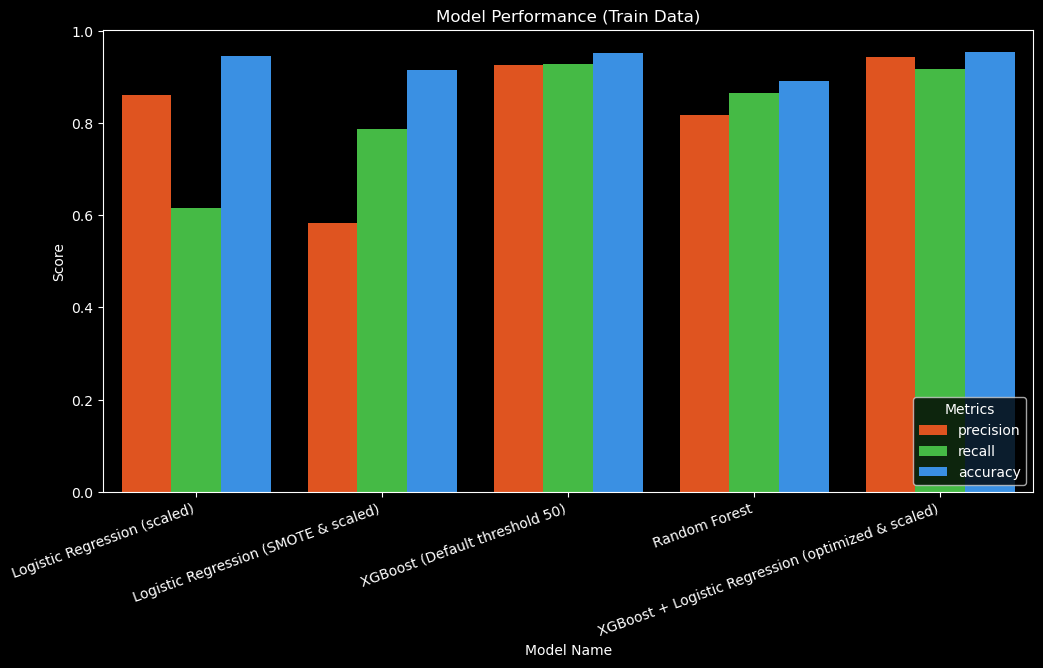

In [80]:
# Re-import necessary libraries
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load stored results into separate DataFrames for test and train
conn = sqlite3.connect("diabetes_results.db")
df_results_test = pd.read_sql("SELECT * FROM model_results WHERE data_type = 'test'", conn)
df_results_train = pd.read_sql("SELECT * FROM model_results WHERE data_type = 'train'", conn)
conn.close()

# Set dark plot style
plt.style.use("dark_background")

# Define brighter colors explicitly
palette = {"precision": "#FF4500", "recall": "#32CD32", "accuracy": "#1E90FF"}

# Function to plot metrics for test and train data separately
def plot_metrics(df, title):
    plt.figure(figsize=(12, 6))
    
    # Reshape DataFrame for seaborn compatibility
    df_melted = df.melt(id_vars='model_name', value_vars=['precision', 'recall', 'accuracy'],
                        var_name='metric', value_name='score')
    
    sns.barplot(data=df_melted, x="model_name", y="score", hue="metric", palette=palette)
    
    # Customize the plot
    plt.xlabel("Model Name")
    plt.ylabel("Score")
    plt.xticks(rotation=20, ha="right")
    plt.title(title)
    plt.legend(title='Metrics', loc='lower right')

    # Show plot
    plt.show()

# Generate separate plots for Test and Train
plot_metrics(df_results_test, "Model Performance (Test Data)")
plot_metrics(df_results_train, "Model Performance (Train Data)")


**Legend**  
    -   **precision: higher the precision, the fewer the false alarms**     
    -   **recall: higher the recall, the model accurately identifies who are diabetic**    

**Line plot for accuracy over Time**

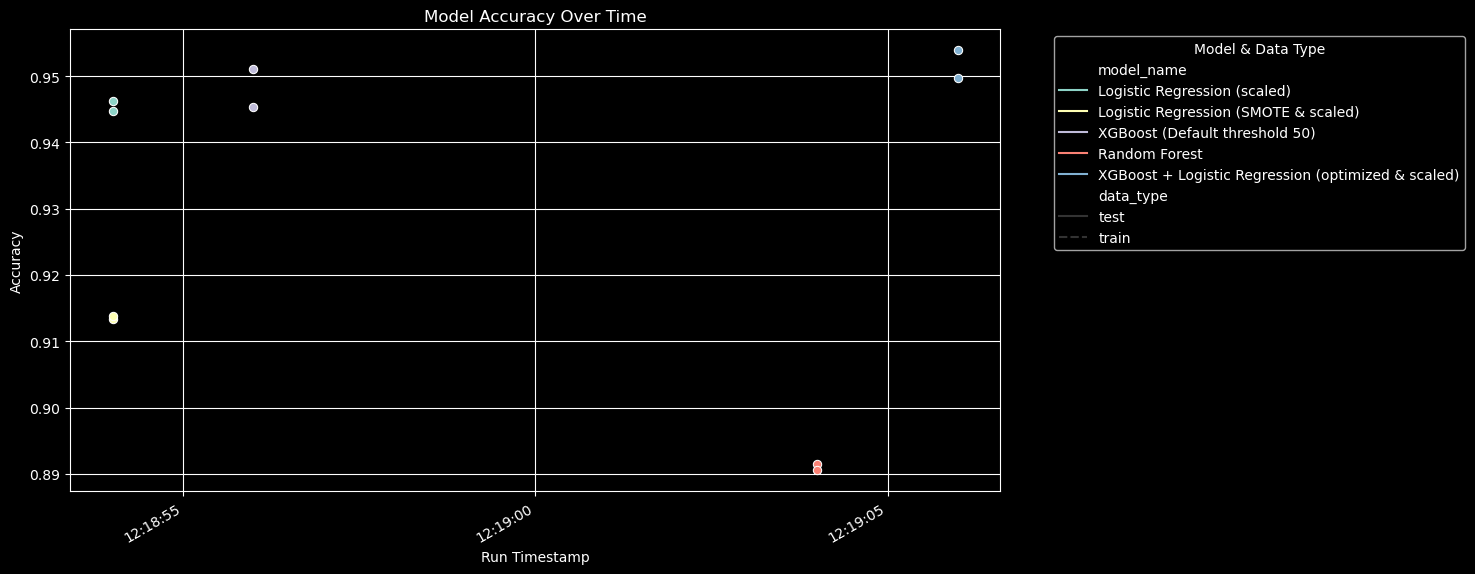

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert timestamp to datetime
df_results['run_timestamp'] = pd.to_datetime(df_results['run_timestamp'])

# Sort by timestamp
df_results = df_results.sort_values(by='run_timestamp')

# Plot accuracy over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_results, x="run_timestamp", y="accuracy", hue="model_name", style="data_type", marker="o")
plt.xticks(rotation=30, ha="right")
plt.xlabel("Run Timestamp")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Over Time")
plt.legend(title="Model & Data Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid()
plt.show()


**Overfitting Analysis**

In [82]:
df_results_pivot = df_results.pivot(index=["model_name", "threshold"], columns="data_type", values="accuracy")
df_results_pivot["overfitting_score"] = df_results_pivot["train"] - df_results_pivot["test"]

# Display models with the highest overfitting scores
df_results_pivot.sort_values(by="overfitting_score", ascending=False)


,data_type,test,train,overfitting_score
model_name,threshold,,,
XGBoost (Default threshold 50),0.5,0.945278,0.951115,0.005838
XGBoost + Logistic Regression (optimized & scaled),0.5,0.949784,0.953887,0.004104
Logistic Regression (scaled),0.5,0.944673,0.946173,0.001501
Logistic Regression (SMOTE & scaled),0.5,0.913373,0.913885,0.000512
Random Forest,0.5,0.891504,0.890536,-0.000968


**Visualize Overfitting Score using Bar Plot**

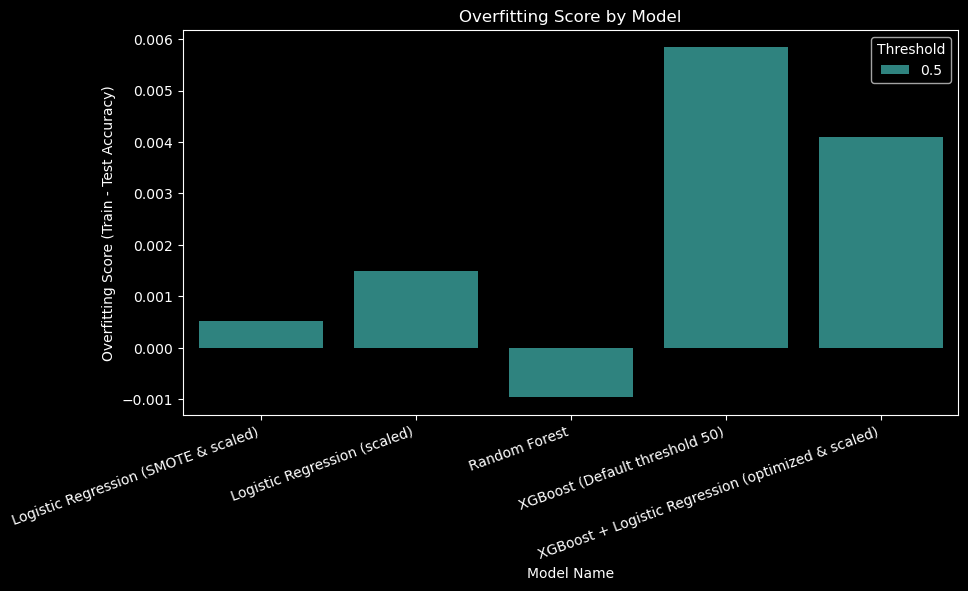

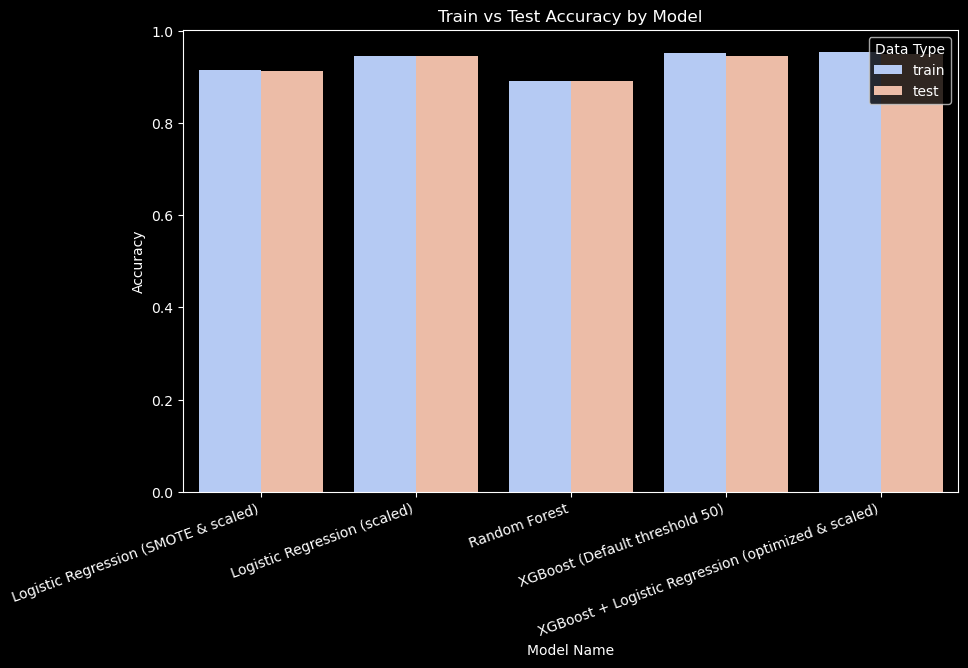

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.barplot(data=df_results_pivot.reset_index(), x="model_name", y="overfitting_score", hue="threshold", palette="viridis")
plt.xlabel("Model Name")
plt.ylabel("Overfitting Score (Train - Test Accuracy)")
plt.title("Overfitting Score by Model")
plt.xticks(rotation=20, ha="right")
plt.legend(title="Threshold")
plt.show()

plt.figure(figsize=(10, 6))
df_melted = df_results_pivot.reset_index().melt(id_vars=["model_name", "threshold"], 
                                                value_vars=["train", "test"],
                                                var_name="data_type", value_name="accuracy")

sns.barplot(data=df_melted, x="model_name", y="accuracy", hue="data_type", palette="coolwarm")
plt.xlabel("Model Name")
plt.ylabel("Accuracy")
plt.xticks(rotation=20, ha="right")
plt.title("Train vs Test Accuracy by Model")
plt.legend(title="Data Type")
plt.show()

